<a href="https://colab.research.google.com/github/roulupen/EVAAssignments/blob/master/Assignment7/Assignment7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

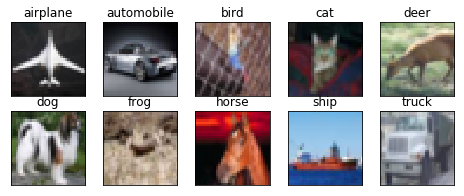

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    # Import currently required to make Lambda work.
    # See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
    import tensorflow as tf
    return tf.space_to_depth(x, block_size=2) 

In [0]:
def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.

    Note: For Lambda with TensorFlow backend, output shape may not be needed.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])

In [10]:
from keras.layers import Input, Conv2D, SeparableConv2D, DepthwiseConv2D, AveragePooling2D, Concatenate, BatchNormalization, MaxPooling2D, Lambda
from keras import regularizers
from keras.models import Model
from keras.layers.merge import concatenate

model_input = Input(shape=(32, 32, 3))


x1 = SeparableConv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(model_input)
x1 = BatchNormalization()(x1)

x2 = Conv2D(64, (5, 5), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(x1)
x2 = BatchNormalization()(x2)

x3_input = Conv2D(16, 1, activation='relu')(x2)
x3 = Conv2D(32, (5, 5), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(x3_input)
x3 = BatchNormalization()(x3)

x4_input = Conv2D(32, 1, activation='relu')(concatenate([x3, x1]))
x4 = SeparableConv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x4_input)
x4 = BatchNormalization()(x4)

x5 = MaxPooling2D((2,2))(concatenate([x4, x1]))
x5 = Conv2D(16, 1, activation='relu')(x5) #1x1 convolution to decrease the number of channel
x5 = Dropout(0.25)(x5)

# Adding space to depth to reshape output
x1 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x1)
x2 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x2)
x4 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x4)
x3 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x3)

x6 = SeparableConv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x5)
x6 = BatchNormalization()(x6)

x7_input = Conv2D(32, 1, activation='relu')(concatenate([x6, x4, x1]))
x7 = Conv2D(64, (5, 5), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(x7_input)
x7 = BatchNormalization()(x7)

x8_input = Conv2D(16, 1, activation='relu')(concatenate([x7, x6, x4, x3]))
x8 = SeparableConv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x8_input)
x8 = BatchNormalization()(x8)

x9_input = Conv2D(16, 1, activation='relu')(concatenate([x8, x7, x6, x4, x3, x1]))
x9 = SeparableConv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x9_input)
x9 = BatchNormalization()(x9)


x10 = MaxPooling2D((2,2))(concatenate([x9,x8,x6,x4,x1]))
x10 = Conv2D(32, 1, activation='relu')(x10) #1x1 convolution to decrease the number of channel
x10 = Dropout(0.25)(x10)

# Adding space to depth to reshape output
x7 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x7)
x8 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x8)
x4 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x4)
x2 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x2)
x6 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x6)
x3 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x3)
x1 = Lambda( space_to_depth_x2, output_shape=space_to_depth_x2_output_shape)(x1)

x11_input = Conv2D(32, 1, activation='relu')(concatenate([x10,x7]))
x11= Conv2D(64, (5, 5), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(x11_input)
x11 = BatchNormalization()(x11)

x12_input = Conv2D(16, 1, activation='relu')(concatenate([x11, x8, x4, x2]))
x12 = SeparableConv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x12_input)
x12 = BatchNormalization()(x12)

x13_input = Conv2D(16, 1, activation='relu')(concatenate([x12,x11, x6, x3, x2]))
x13= Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(x13_input)
x13 = BatchNormalization()(x13)

x14_input = Conv2D(16, 1, activation='relu')(concatenate([x13, x12, x8, x6, x4, x3, x1]))
x14 = SeparableConv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x14_input)
x14 = BatchNormalization()(x14)
x14 = Dropout(0.25)(x14)

x15 = AveragePooling2D((8,8))(x14)
x15 = Conv2D(10, 1, activation='relu')(x15) # Reduce number of channel


x15 = Flatten()(x15)
model_output = Activation(activation='softmax')(x15)


model = Model(model_input, model_output, name='assignment7b')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0616 18:42:03.461472 140386392491904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 18:42:03.466902 140386392491904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 18:42:03.473296 140386392491904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 18:42:03.506843 140386392491904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 18:42:03.507737 1403863924

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   51264       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=97, epochs=30)`
  app.launch_new_instance()
W0616 18:42:09.878878 140386392491904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.a

Epoch 1/30
97/97 [==============================] - 41s 420ms/step - loss: 1.8099 - acc: 0.4049 - val_loss: 2.4419 - val_acc: 0.3594

Epoch 00001: val_acc improved from -inf to 0.35940, saving model to assignment7b.h5
Epoch 2/30
97/97 [==============================] - 34s 354ms/step - loss: 1.2839 - acc: 0.5818 - val_loss: 1.5047 - val_acc: 0.5332

Epoch 00002: val_acc improved from 0.35940 to 0.53320, saving model to assignment7b.h5
Epoch 3/30
97/97 [==============================] - 32s 332ms/step - loss: 1.0727 - acc: 0.6551 - val_loss: 1.2906 - val_acc: 0.5878

Epoch 00003: val_acc improved from 0.53320 to 0.58780, saving model to assignment7b.h5
Epoch 4/30
97/97 [==============================] - 32s 330ms/step - loss: 0.9408 - acc: 0.7053 - val_loss: 1.3469 - val_acc: 0.5991

Epoch 00004: val_acc improved from 0.58780 to 0.59910, saving model to assignment7b.h5
Epoch 5/30
97/97 [==============================] - 32s 333ms/step - loss: 0.8317 - acc: 0.7435 - val_loss: 1.1361 - va

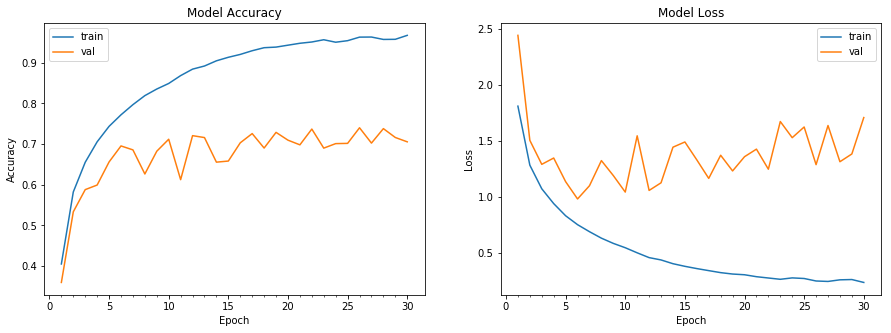

Accuracy on test data is: 74.00


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

checkpointer = ModelCheckpoint(filepath='assignment7b.h5', verbose = 1, save_best_only=True, monitor='val_acc', mode='max')


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 30, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[checkpointer])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
# Load the weights with the best validation accuracy:
model.load_weights('assignment7b.h5')
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))